# Autocorrelation operator estimation

In this notebook we derive the analytical formula for the autocorrelation operator.

## Testing the small-signal approximation model

### Exact model

In [1]:
import numpy as np 
from scipy.stats import norm, halfnorm
from matplotlib import pyplot as plt

In [2]:
def yn(the_i, ynf, u0, tc, t):
    return (
    np.tan(the_i) * u0 * t
    + (3 * ynf - 2 * u0 * tc * np.tan(the_i))/np.square(u0 * tc) * np.square(u0 * t)
    + (u0 * tc * np.tan(the_i) - 2 * ynf)/np.power(u0 * tc, 3) * np.power(u0 * t, 3))

In [3]:
samples_the_i = halfnorm.rvs(loc=0., scale=0.05, size=200)
samples_ynf = norm.rvs(loc=11.88, scale=1., size=200)
u0 = 40.
samples_tc = norm.rvs(loc=7., scale=3., size=200)
t = np.arange(0., 15., 0.1)

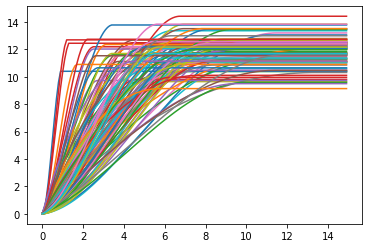

In [4]:
lcdts = np.zeros((200, t.shape[0]))
for i in range(100):
    ts = np.zeros_like(t)
    for j in range(t.shape[0]):
        if j <= samples_tc[i] * 10:
            ts[j] = yn(samples_the_i[i], samples_ynf[i], u0, samples_tc[i], t[j])
        else:
            ts[j] = ts[j-1]
    plt.plot(t, ts)
    lcdts[i,:] = ts

## Karhunen-Loeve Basis for Lanechanging Stochastic Process

In [5]:
import sklearn
import skfda
from skfda.exploratory.visualization import plot_fpca_perturbation_graphs
from skfda.preprocessing.dim_reduction.projection import FPCA

OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [6]:
lcd = skfda.FDataGrid(lcdts, t * 10)

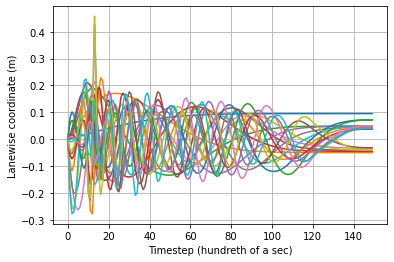

In [7]:
fpca_discretized = FPCA(n_components=20)
fpca_discretized.fit(lcd)
fpca_discretized.components_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Lanewise coordinate (m)')
plt.grid(True)
print('')

In [8]:
basis = fpca_discretized.components_.data_matrix.reshape((-1,150))
mean = fpca_discretized.mean_.data_matrix.reshape(-1)

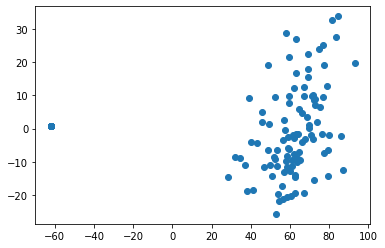

In [9]:
lcdts_coeffs = np.zeros((200,20))
for i in range(200):
    lcdts_coeffs[i,:] = basis @ (lcdts[i,:] - mean)

plt.scatter(lcdts_coeffs[:,0], lcdts_coeffs[:,1])

In [10]:
avgx = np.average(lcdts_coeffs[:,0])
avgy = np.average(lcdts_coeffs[:,1])
lcdts_coeffs[:,0].shape

(200,)

Let's try to decompose the original model?

<BarContainer object of 20 artists>

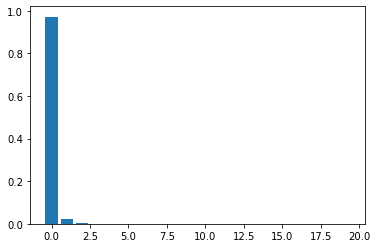

In [11]:
plt.bar(np.arange(20),fpca_discretized.explained_variance_ratio_)

## Learning the distribution of FPCA scores

In [12]:
from sklearn.mixture import GaussianMixture
gm_rw = GaussianMixture(n_components=1, random_state=0).fit(lcdts_coeffs[:,:2])

In [13]:
gm_rw.covariances_

array([[[3948.84981852,   -9.61416395],
        [  -9.61416395,   93.0898561 ]]])

In [14]:
import pickle
pickle.dump(fpca_discretized, open('fpca.pyo', 'wb'))
fpca_discretized.components_.data_matrix[0,:].shape

(150, 1)

## Testing on the sample trajectories

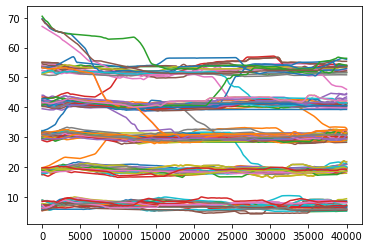

In [15]:
import pickle

pfile = pickle.load(open( "lane.pyo", "rb" ))
tvec = pfile['t_vec'][0]
xvec = pfile['x_vec']

for i in range(xvec.shape[0]):
    plt.plot(tvec, xvec[i,:])

In [16]:
lane_coords = np.array([5.4, 19.1, 30.8, 41.2, 52.9])
lane_width = 0
for i in range(lane_coords.shape[0]-1):
    lane_width += lane_coords[i+1] - lane_coords[i]
lane_width = lane_width/4
print('Lane coordinates: {}; Lane width: {}'.format(lane_coords, lane_width))

Lane coordinates: [ 5.4 19.1 30.8 41.2 52.9]; Lane width: 11.874999999999998


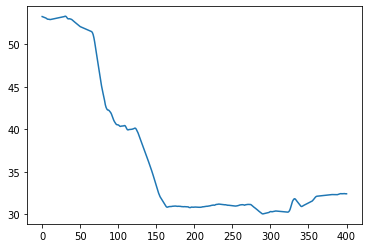

In [17]:
# sample_traj = xvec[16,:]
sample_traj = xvec[16,:]
plt.plot(sample_traj)

In [18]:
pickle.dump(sample_traj ,open('sample.pyo', 'wb'))

In [19]:
import pickle
pickle.dump(fpca_discretized, open('fpca.pyo', 'wb'))

### What if we use LC basis for LK? Let's see what would happen.

Customize for lane 5 to lane 4 change

In [20]:
basis_p = -basis 
mean_p = -mean + 52.9

In [21]:
coeffs = np.zeros((tvec.shape[0] - lcdts.shape[1],20))
windows = np.zeros((tvec.shape[0] - lcdts.shape[1],lcdts.shape[1]))
for wi in range(tvec.shape[0] - lcdts.shape[1]):
    # Calculate the coefficients for each time window starting from wi 
    windowed_traj = np.clip(sample_traj[wi:wi + lcdts.shape[1]], 38., 53.) - mean_p
    window = (windowed_traj - windowed_traj[0]).reshape(-1,1)
    windows[wi,:] = window.reshape(-1)
    coeffs[wi,:] = (basis_p @ window ).reshape(-1)

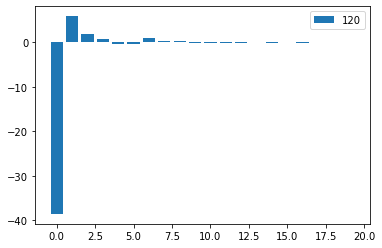

In [136]:
for wi in [120]:
    plt.bar(np.arange(20),coeffs[wi,:], label=wi)

plt.legend()


In [129]:
coeffs[50,:]

array([ 80.6167786 , -10.33070482,  -5.65487668,  -6.64187313,
         4.24924805,   2.61450357,   0.38411526,  -0.341968  ,
         1.84375509,  -0.6113131 ,   0.89717709,   0.43189678,
         1.17526045,   0.20323014,   0.17072154,   0.63579368,
        -0.86191745,   0.69351648,  -0.56528876,   0.40895427])

Let's plot out the energy share by the largest eigenvalues

In [24]:
energy_total = np.sum(coeffs[:,:]**2, axis=1)
energy_share = np.zeros((5,coeffs.shape[0]))
energy_first = np.zeros((5,coeffs.shape[0]))
for n in range(5):
    energy_n = np.sum(coeffs[:,:n+1]**2, axis=1)
    energy_first[n,:] = energy_n
    energy_share[n,:] = energy_n/energy_total

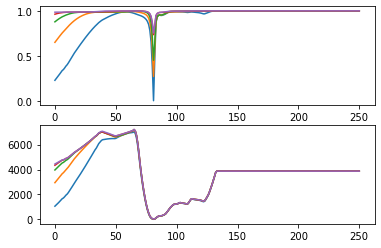

In [25]:
plt.subplot(2,1,1)
for n in range(5):
    plt.plot(energy_share[n,:])
plt.subplot(2,1,2)
for n in range(5):
    plt.plot(energy_first[n,:])

# Detection of Changepoint

We can take advantage of the energy share function to detect lane changing behaviours

In [26]:
np.random.seed(6969)
import bocd

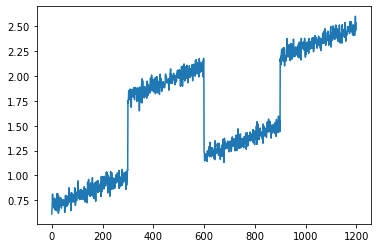

In [60]:
test_signal = np.concatenate(
    [np.random.normal(0.7, 0.05, 300) , 
     np.random.normal(1.5, 0.05, 300),
     np.random.normal(0.6, 0.05, 300),
     np.random.normal(1.3, 0.05, 300)]) + np.array(range(1200))  / 1000.0
plt.plot(test_signal)

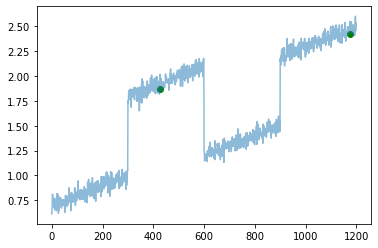

In [104]:
# Initialize object
bc = bocd.BayesianOnlineChangePointDetection(bocd.ConstantHazard(400), bocd.StudentT(mu=-10, kappa=1, alpha=1, beta=1))

# Online estimation and get the maximum likelihood r_t at each time point
rt_mle = np.empty(test_signal.shape)
for i, d in enumerate(test_signal):
    bc.update(d)
    rt_mle[i] = bc.rt

# Plot data with estimated change points
plt.plot(test_signal, alpha=0.5, label="observation")
index_changes = np.where(np.diff(rt_mle)<0)[0]
plt.scatter(index_changes, test_signal[index_changes], c='green', label="change point")

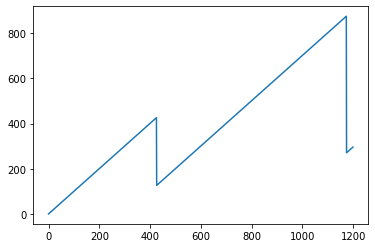

In [105]:
plt.plot(rt_mle)

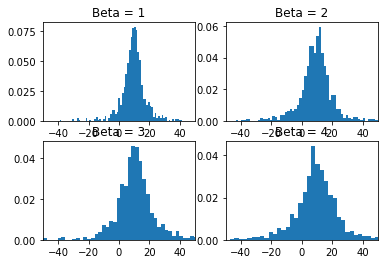

In [97]:
for beta in range(1,5):
    t_dist = bocd.StudentT(mu=10, kappa=1, alpha=1, beta=beta * 10)
    from scipy.stats import t
    t_samples = t.rvs(loc=t_dist.muT,
        df=2 * t_dist.alphaT,
        scale=np.sqrt(t_dist.betaT * (t_dist.kappaT + 1) / (t_dist.alphaT * t_dist.kappaT)),
        size=1000)
    plt.subplot(2,2,beta)
    plt.title('Beta = {:d}'.format(beta))
    plt.xlim((-50,50))
    plt.hist(t_samples, density=True, bins=200)

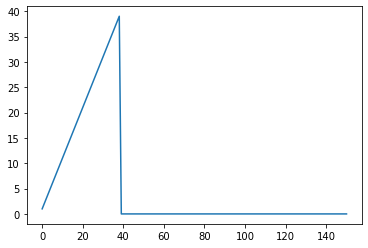

In [125]:
# Initialize object
bc = bocd.BayesianOnlineChangePointDetection(bocd.ConstantHazard(10), bocd.StudentT(mu=0, kappa=1, alpha=1, beta=0.1))

# Online estimation and get the maximum likelihood r_t at each time point
rt_mle = np.empty(energy_share[1,100:].shape)
for i, d in enumerate(energy_share[1,100:]):
    bc.update(d)
    rt_mle[i] = bc.rt 

plt.plot(rt_mle)

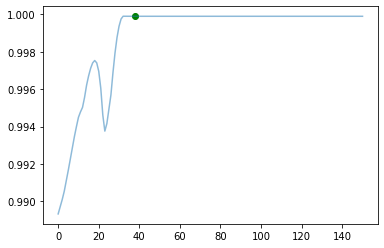

In [127]:
plt.plot(energy_share[1,100:], alpha=0.5, label="observation")
index_changes = np.where(np.diff(rt_mle)<0)[0]
plt.scatter(index_changes, energy_share[1,100+index_changes], c='green', label="change point")